# Test setindeki missing valuelar ile nasıl ilgilenilmelidir?

Train datası içerisinde bulunan kayıp değerler ile doğru ilgilenilmediği takdirde modelin öğrenimi düzgün bir şekilde gerçekleşmez ve güvenilmez bir model elde edilmiş olur. Bu noktada ilgilenmek için kullanılan yolun test datası içerisinde bulunan kayıp değerler ile ilgilenmek için de kullanılması gerekmektedir. Çünkü test datasının gerçek hayatı yansıtması gerekmektedir. Bu nedenle gelebilecek değerlerin aralığı belirlenemeyebilmekte ve kendi içerisinde bir imputation kullanmak pek mantıklı olmayabilir. Kendi düşüncem bu noktada iki durum izlenebilir, missing value içeren satırlar test setinden düşürülüp kullanılmayabilir ve model düzgün test edilmiş olur. Ya da train için kullanılan değerler burada da kullanılmalıdır.

In [236]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [237]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

import pandas as pd
import numpy as np

import math

from string import punctuation

In [238]:
df_raw = pd.read_csv("hotel_bookings.csv", low_memory=False, parse_dates=["reservation_status_date"])

In [239]:
df_raw = pd.get_dummies(df_raw, columns=["hotel"], drop_first=True)
df_raw.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,hotel_Resort Hotel
0,0,342,2015,July,27,1,0,0,2,0.0,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.0,...,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
2,0,7,2015,July,27,1,0,1,1,0.0,...,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
3,0,13,2015,July,27,1,0,1,1,0.0,...,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
4,0,14,2015,July,27,1,0,2,2,0.0,...,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,1


In [240]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   is_canceled                     119390 non-null  int64         
 1   lead_time                       119390 non-null  int64         
 2   arrival_date_year               119390 non-null  int64         
 3   arrival_date_month              119390 non-null  object        
 4   arrival_date_week_number        119390 non-null  int64         
 5   arrival_date_day_of_month       119390 non-null  int64         
 6   stays_in_weekend_nights         119390 non-null  int64         
 7   stays_in_week_nights            119390 non-null  int64         
 8   adults                          119390 non-null  int64         
 9   children                        119386 non-null  float64       
 10  babies                          119390 non-null  int64  

In [241]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000):
        display(df)

In [242]:
display_all(df_raw.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,hotel_Resort Hotel
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01,1
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02,1
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03,1


In [243]:
display_all(df_raw.isnull().sum())

is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_

In [244]:
display_all(df_raw.tail(20).T)

,119370,119371,119372,119373,119374,119375,119376,119377,119378,119379,119380,119381,119382,119383,119384,119385,119386,119387,119388,119389
is_canceled,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
lead_time,201,175,175,175,201,200,165,185,247,109,44,188,135,164,21,23,102,34,109,205
arrival_date_year,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017,2017
arrival_date_month,August,August,August,August,August,August,August,August,August,August,August,August,August,August,August,August,August,August,August,August
arrival_date_week_number,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35,35
arrival_date_day_of_month,30,31,31,31,29,30,29,30,31,31,31,31,30,31,30,30,31,31,31,29
stays_in_weekend_nights,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2
stays_in_week_nights,4,3,3,3,5,4,5,4,3,3,3,3,4,4,5,5,5,5,5,7
adults,1,2,1,1,2,2,3,2,2,2,2,2,3,2,2,2,3,2,2,2
children,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [245]:
display_all(df_raw.describe(include='all').T)

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
is_canceled,119390,NaN,NaN,NaN,NaT,NaT,0.370416,0.482918,0,0,0,1,1
lead_time,119390,NaN,NaN,NaN,NaT,NaT,104.011,106.863,0,18,69,160,737
arrival_date_year,119390,NaN,NaN,NaN,NaT,NaT,2016.16,0.707476,2015,2016,2016,2017,2017
arrival_date_month,119390,12,August,13877,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival_date_week_number,119390,NaN,NaN,NaN,NaT,NaT,27.1652,13.6051,1,16,28,38,53
arrival_date_day_of_month,119390,NaN,NaN,NaN,NaT,NaT,15.7982,8.78083,1,8,16,23,31
stays_in_weekend_nights,119390,NaN,NaN,NaN,NaT,NaT,0.927599,0.998613,0,0,1,2,19
stays_in_week_nights,119390,NaN,NaN,NaN,NaT,NaT,2.5003,1.90829,0,1,2,3,50
adults,119390,NaN,NaN,NaN,NaT,NaT,1.8564,0.579261,0,2,2,2,55
children,119386,NaN,NaN,NaN,NaT,NaT,0.10389,0.398561,0,0,0,0,10


In [247]:
# m = RandomForestClassifier(n_jobs=-1)
# m.fit(df_raw.drop(["hotel_Resort Hotel"],axis=1),df_raw["hotel_Resort Hotel"])

## 2) Pre-processing

In [248]:
import re
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [249]:
df_compare = df_raw.copy()

In [250]:
df_compare.drop(["reservation_status_date"], axis=1, inplace=True)

In [251]:
df_raw["reservation_status_date"].dt.day

0         1
1         1
2         2
3         2
4         3
         ..
119385    6
119386    7
119387    7
119388    7
119389    7
Name: reservation_status_date, Length: 119390, dtype: int64

In [252]:
re.sub('[Dd]ate$', '', "reservation_status_date")

'reservation_status_'

In [253]:
#dt_name is the name of the column that is of type datepart
def add_datepart(df, dt_name, drop=True, time=False):
    "Creates new columns from our datetime column"    
    dt_column = df[dt_name]
    column_dtype = dt_column.dtype
    
    targ_name = re.sub('[Dd]ate$', '', dt_name)
    
    # attributes are normally in lower case but we wrote this way because we will use it in columns' name too
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    if time: 
        attr = attr + ['Hour', 'Minute', 'Second'] 
    
    #Sorry curse of dimensionality, maybe another time
    for a in attr: 
        df[targ_name + a] = getattr(dt_column.dt, a.lower())
        
    # how much time passed, we will divide by 10^9 because it is in the nanosecond format
    df[targ_name + 'Elapsed'] = dt_column.astype(np.int64) // 10 ** 9
    
    if drop: 
        df.drop(dt_name, axis=1, inplace=True)

In [254]:
add_datepart(df_raw, "reservation_status_date")

In [255]:
display_all(df_raw.head().T)

,0,1,2,3,4
is_canceled,0,0,0,0,0
lead_time,342,737,7,13,14
arrival_date_year,2015,2015,2015,2015,2015
arrival_date_month,July,July,July,July,July
arrival_date_week_number,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2
children,0,0,0,0,0


### Creating Mapping For Categorical Variables

In [256]:
a = df_raw.items()
next(a)

('is_canceled',
 0         0
 1         0
 2         0
 3         0
 4         0
          ..
 119385    0
 119386    0
 119387    0
 119388    0
 119389    0
 Name: is_canceled, Length: 119390, dtype: int64)

In [257]:
next(a)

('lead_time',
 0         342
 1         737
 2           7
 3          13
 4          14
          ... 
 119385     23
 119386    102
 119387     34
 119388    109
 119389    205
 Name: lead_time, Length: 119390, dtype: int64)

In [258]:
type(next(a))

tuple

In [259]:
def train_cats(df):
    for n,c in df.items():
        if is_string_dtype(c):
            df[n] = c.astype("category").cat.as_ordered()

In [260]:
def apply_cats(df, train):
    for n,c in df.items():
        if train[n].dtype() == "category":
            df[n] = pd.Categorical(c, categories = df[n].cat.categories, ordered=True)

In [261]:
df = df_raw.copy()
display_all(df.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,hotel_Resort Hotel,reservation_status_Year,reservation_status_Month,reservation_status_Week,reservation_status_Day,reservation_status_Dayofweek,reservation_status_Dayofyear,reservation_status_Is_month_end,reservation_status_Is_month_start,reservation_status_Is_quarter_end,reservation_status_Is_quarter_start,reservation_status_Is_year_end,reservation_status_Is_year_start,reservation_status_Elapsed
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1,2015,7,27,1,2,182,False,True,False,True,False,False,1435708800
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1,2015,7,27,1,2,182,False,True,False,True,False,False,1435708800
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,1,2015,7,27,2,3,183,False,False,False,False,False,False,1435795200
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,1,2015,7,27,2,3,183,False,False,False,False,False,False,1435795200
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,1,2015,7,27,3,4,184,False,False,False,False,False,False,1435881600


In [262]:
train_cats(df)

In [263]:
train_cats(df_compare)

In [264]:
import os
os.makedirs("tmp", exist_ok=True)
df.to_feather("tmp/hotel_bookings")

# Model

In [29]:
df = pd.read_feather("tmp/hotel_bookings")

In [30]:
display_all(df.head(8))

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,hotel_Resort Hotel,reservation_status_Year,reservation_status_Month,reservation_status_Week,reservation_status_Day,reservation_status_Dayofweek,reservation_status_Dayofyear,reservation_status_Is_month_end,reservation_status_Is_month_start,reservation_status_Is_quarter_end,reservation_status_Is_quarter_start,reservation_status_Is_year_end,reservation_status_Is_year_start,reservation_status_Elapsed
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1,2015,7,27,1,2,182,False,True,False,True,False,False,1435708800
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,1,2015,7,27,1,2,182,False,True,False,True,False,False,1435708800
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,1,2015,7,27,2,3,183,False,False,False,False,False,False,1435795200
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,1,2015,7,27,2,3,183,False,False,False,False,False,False,1435795200
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,1,2015,7,27,3,4,184,False,False,False,False,False,False,1435881600
5,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,1,2015,7,27,3,4,184,False,False,False,False,False,False,1435881600
6,0,0,2015,July,27,1,0,2,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,NaN,NaN,0,Transient,107.0,0,0,Check-Out,1,2015,7,27,3,4,184,False,False,False,False,False,False,1435881600
7,0,9,2015,July,27,1,0,2,2,0.0,0,FB,PRT,Direct,Direct,0,0,0,C,C,0,No Deposit,303.0,NaN,0,Transient,103.0,0,1,Check-Out,1,2015,7,27,3,4,184,False,False,False,False,False,False,1435881600


In [31]:
display_all(df.isnull().sum().sort_index()/len(df))

adr                                    0.000000
adults                                 0.000000
agent                                  0.136862
arrival_date_day_of_month              0.000000
arrival_date_month                     0.000000
arrival_date_week_number               0.000000
arrival_date_year                      0.000000
assigned_room_type                     0.000000
babies                                 0.000000
booking_changes                        0.000000
children                               0.000034
company                                0.943069
country                                0.004087
customer_type                          0.000000
days_in_waiting_list                   0.000000
deposit_type                           0.000000
distribution_channel                   0.000000
hotel_Resort Hotel                     0.000000
is_canceled                            0.000000
is_repeated_guest                      0.000000
lead_time                              0

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 44 columns):
 #   Column                               Non-Null Count   Dtype   
---  ------                               --------------   -----   
 0   is_canceled                          119390 non-null  int64   
 1   lead_time                            119390 non-null  int64   
 2   arrival_date_year                    119390 non-null  int64   
 3   arrival_date_month                   119390 non-null  category
 4   arrival_date_week_number             119390 non-null  int64   
 5   arrival_date_day_of_month            119390 non-null  int64   
 6   stays_in_weekend_nights              119390 non-null  int64   
 7   stays_in_week_nights                 119390 non-null  int64   
 8   adults                               119390 non-null  int64   
 9   children                             119386 non-null  float64 
 10  babies                               119390 non-null  int64   
 11  

In [33]:
def fix_missing(df, name, col):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum:
            df[name+"_na"] = pd.isnull(col)
        df[name] = col.fillna(col.median())

In [34]:
def numericalize(df, name, col):
    if not is_numeric_dtype(col):
        df[name] = col.cat.codes + 1

In [35]:
def proc_df(df, y_col):
    
    y = df[y_col].values
    df.drop(y_col, axis=1, inplace=True)
    
    for n,c in df.items():
        fix_missing(df, n, c)
        numericalize(df, n, c)
        
    res = [df, y]
    
    return res

In [36]:
df,y = proc_df(df, "hotel_Resort Hotel")

In [37]:
display_all(df.isnull().sum())

is_canceled                               0
lead_time                                 0
arrival_date_year                         0
arrival_date_month                        0
arrival_date_week_number                  0
arrival_date_day_of_month                 0
stays_in_weekend_nights                   0
stays_in_week_nights                      0
adults                                    0
children                                  0
babies                                    0
meal                                      0
country                                   0
market_segment                            0
distribution_channel                      0
is_repeated_guest                         0
previous_cancellations                    0
previous_bookings_not_canceled            0
reserved_room_type                        0
assigned_room_type                        0
booking_changes                           0
deposit_type                              0
agent                           

In [38]:
df_compare, y_compare = proc_df(df_compare, "hotel_Resort Hotel")

In [39]:
m = RandomForestClassifier(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

1.0

In [140]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(df, y, random_state=42, test_size=0.1)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=42, test_size=0.2)

X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((85960, 76), (11939, 76), (21491, 76), (85960,), (11939,), (21491,))

In [134]:
def print_score(m):
    
    reg_metrics = {
                        "Accuracy Score": [metrics.accuracy_score(y_train, m.predict(X_train)), metrics.accuracy_score(y_valid, m.predict(X_valid)),metrics.accuracy_score(y_test, m.predict(X_test))],
                        "F1 Score": [metrics.f1_score(y_train, m.predict(X_train)), metrics.f1_score(y_valid, m.predict(X_valid)), metrics.f1_score(y_test, m.predict(X_test))],
                        "Roc Auc Score": [metrics.roc_auc_score(y_train, m.predict(X_train)), metrics.roc_auc_score(y_valid, m.predict(X_valid)), metrics.roc_auc_score(y_test, m.predict(X_test))]
                  }
    
    df_reg_metrics = pd.DataFrame.from_dict(reg_metrics, orient='index', columns=["Train", "Validation", "Test"])
    return df_reg_metrics

In [91]:
X_train

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reservation_status_Day_na,reservation_status_Dayofweek_na,reservation_status_Dayofyear_na,reservation_status_Is_month_end_na,reservation_status_Is_month_start_na,reservation_status_Is_quarter_end_na,reservation_status_Is_quarter_start_na,reservation_status_Is_year_end_na,reservation_status_Is_year_start_na,reservation_status_Elapsed_na
76010,1,336,2015,12,38,18,0,2,2,0.0,...,False,False,False,False,False,False,False,False,False,False
118410,0,120,2017,2,33,16,0,4,2,0.0,...,False,False,False,False,False,False,False,False,False,False
68563,1,105,2017,9,20,19,0,2,1,0.0,...,False,False,False,False,False,False,False,False,False,False
114113,0,145,2017,7,24,15,0,2,2,0.0,...,False,False,False,False,False,False,False,False,False,False
42327,0,82,2015,12,36,5,0,1,2,0.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69605,1,129,2017,7,22,2,1,2,2,0.0,...,False,False,False,False,False,False,False,False,False,False
60772,1,160,2016,10,48,20,2,3,2,0.0,...,False,False,False,False,False,False,False,False,False,False
1898,1,158,2015,12,39,20,2,5,2,0.0,...,False,False,False,False,False,False,False,False,False,False
74743,1,329,2015,12,37,11,2,3,1,0.0,...,False,False,False,False,False,False,False,False,False,False


In [92]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 6.92 s


,Train,Validation,Test
Accuracy Score,1.0,0.987101,0.986646
F1 Score,1.0,0.980926,0.980029
Roc Auc Score,1.0,0.984717,0.984282


## Trying Different Things Fast

In [93]:
def get_sample(df,n):
    idxs = np.random.permutation(len(df))[:n]
    return idxs, df.iloc[idxs].copy()

In [94]:
def proc_df(df, y_col):
    y = df[y_col].values
    df.drop(y_col, axis=1, inplace=True)
    for n,c in df.items():
        fix_missing(df, n, c)
        numericalize(df, n, c)
    res = [df, y]
    return res

In [95]:
df2 = pd.read_feather("tmp/hotel_bookings")

In [96]:
df2, y2 = proc_df(df2, 'is_canceled')

In [97]:
# n_valid = 30000
# n_train = len(df) - n_valid
# X_train, X_valid = split_train_val(df, n_train)
# y_train, y_valid = split_train_val(y, n_train)

# X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

In [141]:
idxs, X_train = get_sample(X_train, 1000)
y_train = y_train[idxs]

X_train.shape, y_train.shape

((1000, 76), (1000,))

In [142]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 549 ms


,Train,Validation,Test
Accuracy Score,1.0,0.941955,0.941464
F1 Score,1.0,0.913666,0.911843
Roc Auc Score,1.0,0.932967,0.931869


# Single Tree

In [143]:
from sklearn import tree
import matplotlib.pyplot as plt

In [144]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

,Train,Validation,Test
Accuracy Score,0.884000,0.884077,0.884370
F1 Score,0.825301,0.829515,0.829057
Roc Auc Score,0.862750,0.871160,0.872420


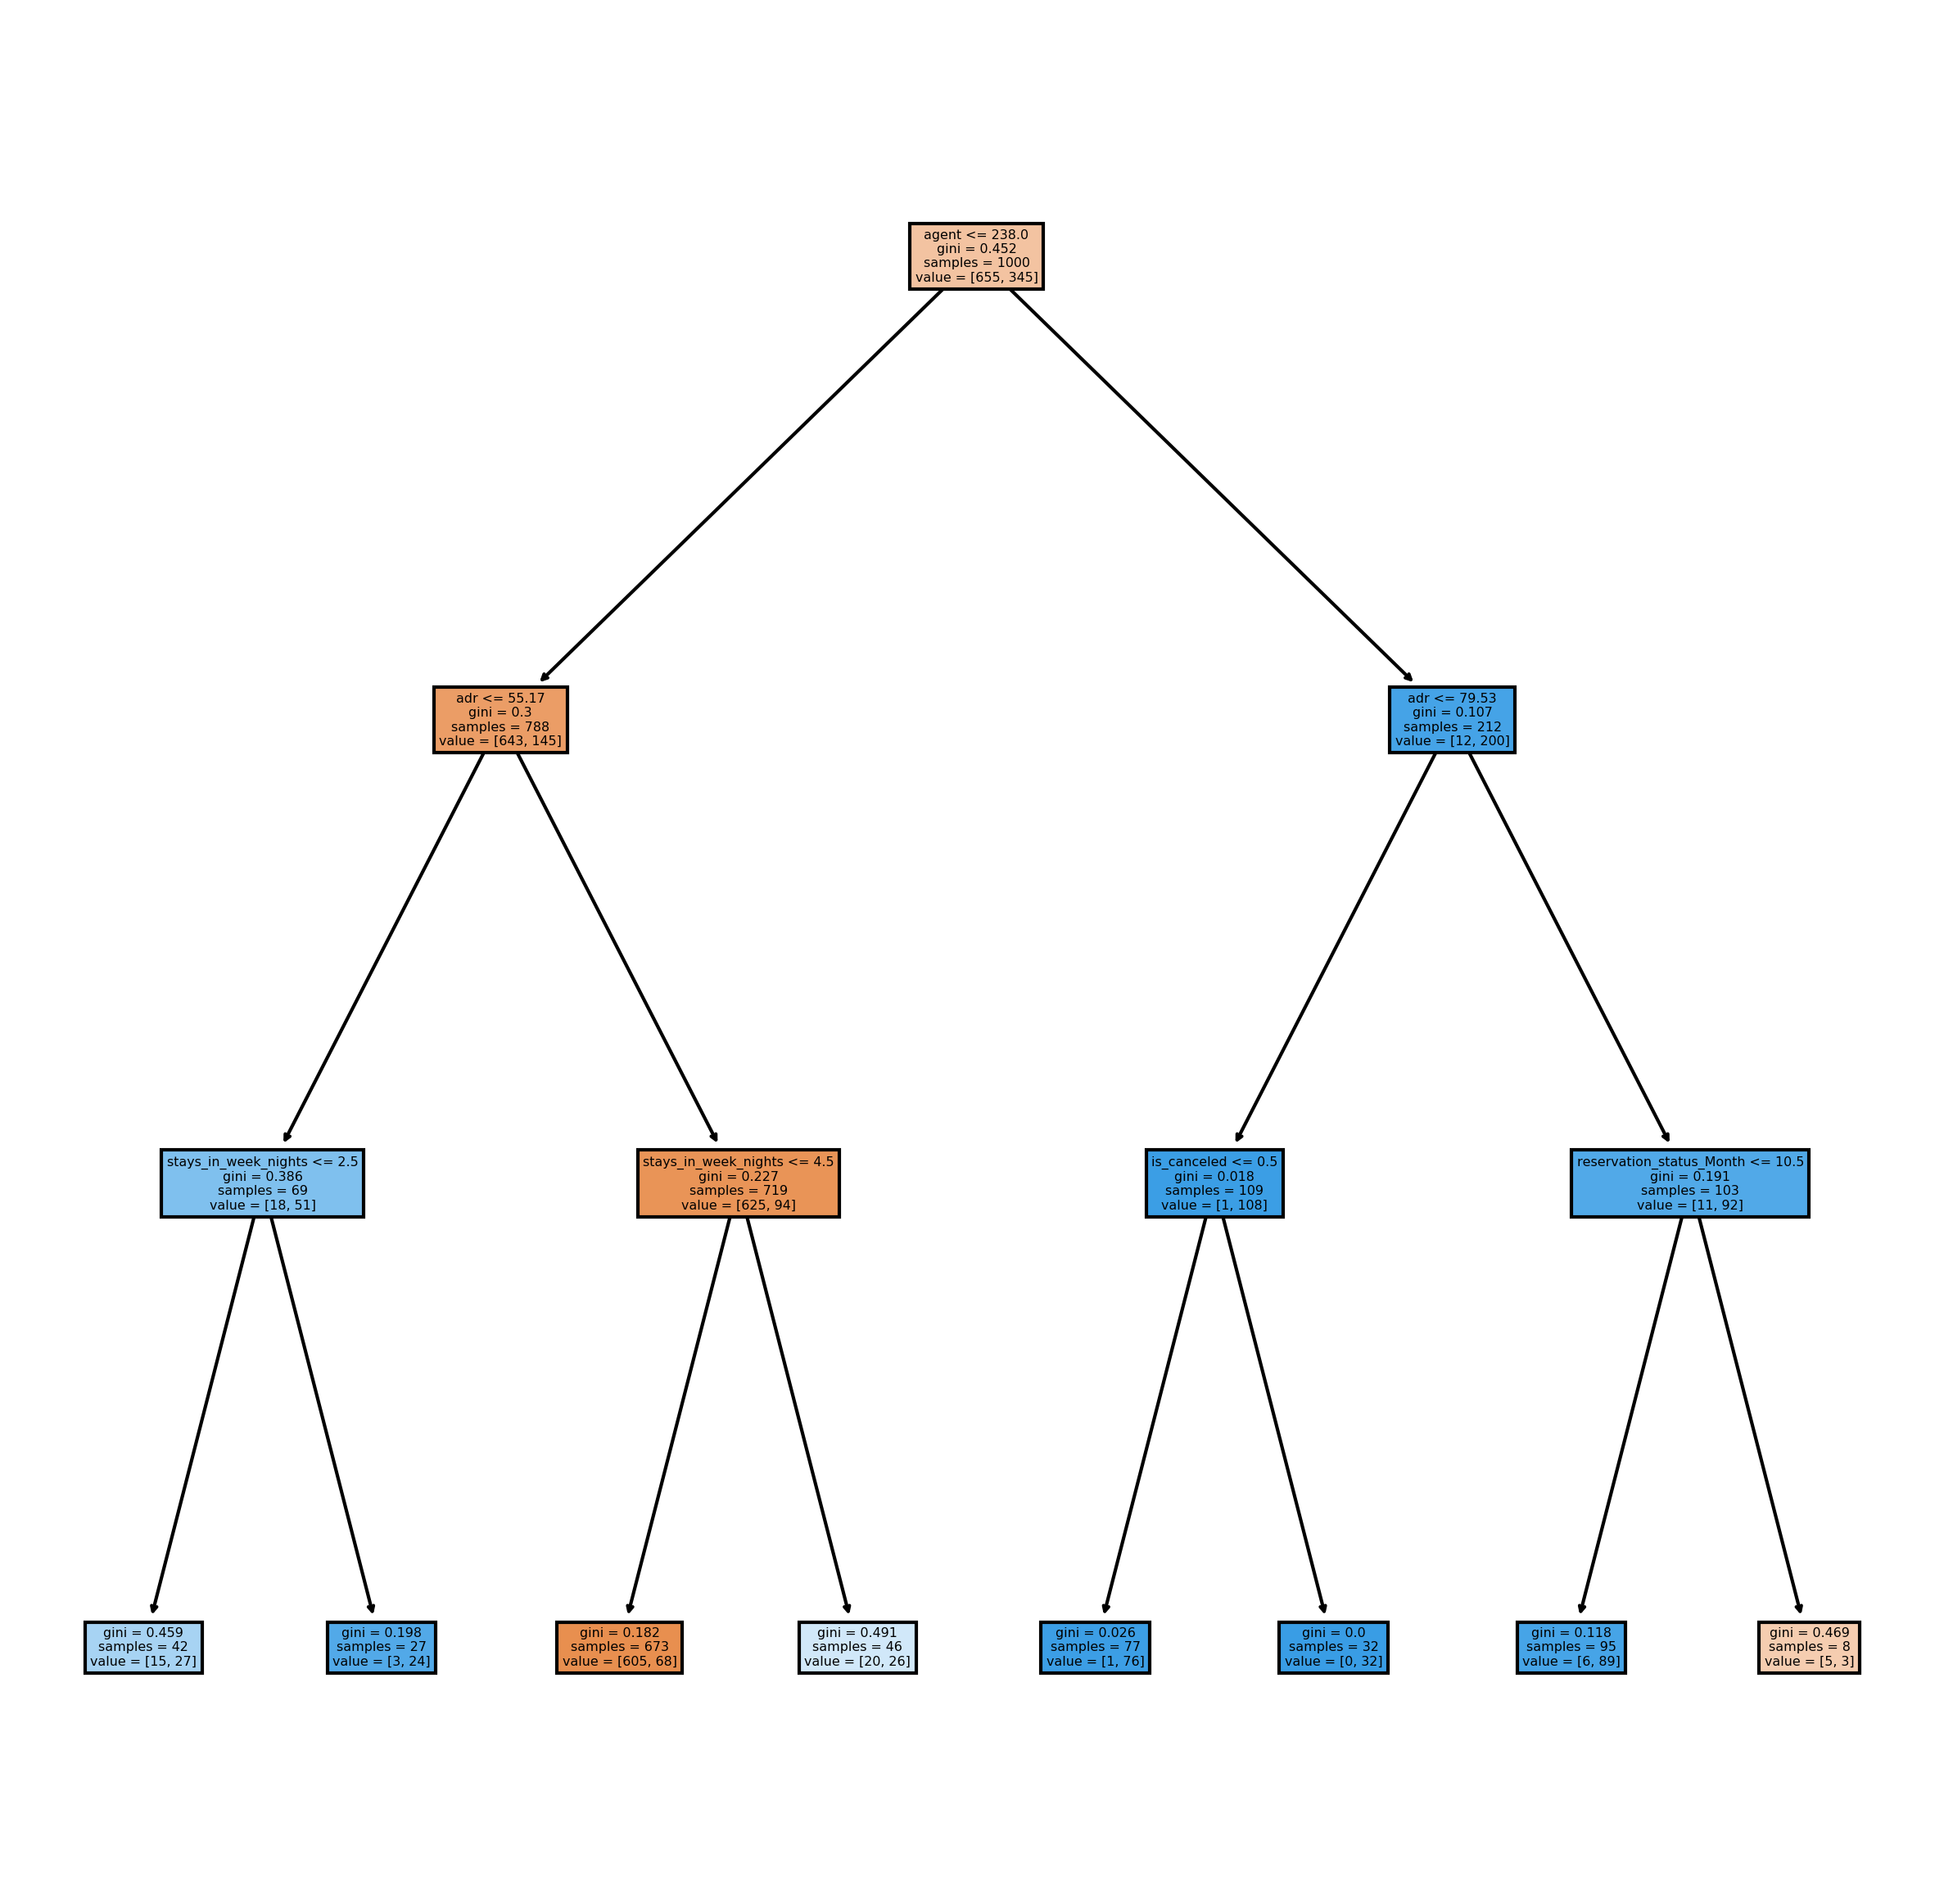

In [145]:
estimator = m.estimators_[0]
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=300)
tree.plot_tree(estimator, feature_names=df.columns,filled=True);

In [129]:
m = RandomForestClassifier(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

,Train,Validation,Test
Accuracy Score,0.753000,0.740263,0.736913
F1 Score,0.641509,0.623711,0.615165
Roc Auc Score,0.726709,0.714490,0.709692


In [128]:
m = RandomForestClassifier(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 538 ms


,Train,Validation,Test
Accuracy Score,1.0,0.938940,0.939044
F1 Score,1.0,0.907452,0.907053
Roc Auc Score,1.0,0.925105,0.926131


In [109]:
preds = np.array([t.predict(X_valid) for t in m.estimators_]) # list of arrays of predictions
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
        1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 0.85,
 1)

In [111]:
preds.shape, X_valid.shape # (number of trees, size of the validation set)

((100, 11939), (11939, 76))

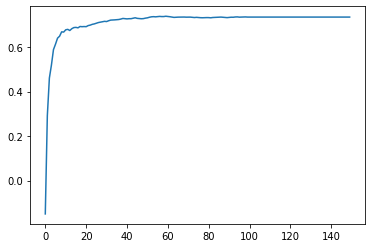

In [123]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(150)]);

In [126]:
m = RandomForestClassifier(n_estimators=60, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

,Train,Validation,Test
Accuracy Score,1.0,0.938772,0.940812
F1 Score,1.0,0.907104,0.909272
Roc Auc Score,1.0,0.924678,0.926842


In [131]:
m = RandomForestClassifier(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

,Train,Validation,Test
Accuracy Score,1.0,0.939023,0.939835
F1 Score,1.0,0.907473,0.908096
Roc Auc Score,1.0,0.924928,0.926588


In [149]:
def print_score(m):
    
    reg_metrics = {
                        "Accuracy Score": [metrics.accuracy_score(y_train, m.predict(X_train)), metrics.accuracy_score(y_valid, m.predict(X_valid)),metrics.accuracy_score(y_test, m.predict(X_test))],
                        "F1 Score": [metrics.f1_score(y_train, m.predict(X_train)), metrics.f1_score(y_valid, m.predict(X_valid)), metrics.f1_score(y_test, m.predict(X_test))],
                        "Roc Auc Score": [metrics.roc_auc_score(y_train, m.predict(X_train)), metrics.roc_auc_score(y_valid, m.predict(X_valid)), metrics.roc_auc_score(y_test, m.predict(X_test))]
                        
                  }
    
    df_reg_metrics = pd.DataFrame.from_dict(reg_metrics, orient='index', columns=["Train", "Validation", "Test"])
    if hasattr(m, "oob_score_"):
        print(f"OOB score: {m.oob_score_}")
    return df_reg_metrics

In [150]:
m = RandomForestClassifier(n_estimators=60, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

OOB score: 0.935


,Train,Validation,Test
Accuracy Score,1.0,0.936427,0.937043
F1 Score,1.0,0.905113,0.905126
Roc Auc Score,1.0,0.925963,0.926757


# Reducing over-fitting

In [170]:
df = pd.read_feather("tmp/hotel_bookings")

In [171]:
df_trn, y_trn = proc_df(df, 'hotel_Resort Hotel')

In [156]:
X_train, X_valid, y_train, y_valid = train_test_split(df_trn, y_trn, random_state=42, test_size=0.1)

In [158]:
from sklearn.ensemble import forest

In [159]:
np.random.mtrand._rand.randint(0,10,3)

array([2, 7, 0])

In [160]:
def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

In [161]:
def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

In [164]:
set_rf_samples(10000)

In [177]:
m = RandomForestClassifier(n_estimators=60, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 8.12 s
OOB score: 0.9875478124912751


,Train,Validation,Test
Accuracy Score,0.999991,0.988022,1.0
F1 Score,0.999986,0.982295,1.0
Roc Auc Score,0.999986,0.985834,1.0


In [179]:
m = RandomForestClassifier(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 13.2 s
OOB score: 0.9883202576057925


,Train,Validation,Test
Accuracy Score,1.0,0.987855,1.0
F1 Score,1.0,0.982052,1.0
Roc Auc Score,1.0,0.985708,1.0


In [180]:
reset_rf_samples()

In [193]:
m = RandomForestClassifier(n_estimators=60, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 6.54 s
OOB score: 0.9876315716000782


,Train,Validation,Test
Accuracy Score,1.0,0.987520,1.0
F1 Score,1.0,0.981534,1.0
Roc Auc Score,1.0,0.985034,1.0


In [184]:
%prun m.fit(X_train, y_train)

### Using min_sample_leaf

In [208]:
m = RandomForestClassifier(n_estimators=60, min_samples_leaf=1, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 6.21 s
OOB score: 0.9872686154619315


,Train,Validation,Test
Accuracy Score,1.0,0.988441,1.0
F1 Score,1.0,0.982921,1.0
Roc Auc Score,1.0,0.986391,1.0


In [207]:
m = RandomForestClassifier(n_estimators=60, min_samples_leaf=3, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 6.27 s
OOB score: 0.9851560246065648


,Train,Validation,Test
Accuracy Score,0.995952,0.985175,0.995347
F1 Score,0.993954,0.978086,0.993057
Roc Auc Score,0.995227,0.982659,0.994609


### Using max_features to Add Randomness to Split

In [209]:
m = RandomForestClassifier(n_estimators=60, min_samples_leaf=1, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 15 s
OOB score: 0.9904049287582247


,Train,Validation,Test
Accuracy Score,0.999991,0.990786,1.0
F1 Score,0.999986,0.986416,1.0
Roc Auc Score,0.999986,0.989546,1.0


In [210]:
m = RandomForestClassifier(n_estimators=60, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

Wall time: 15.4 s
OOB score: 0.9889158779350588


,Train,Validation,Test
Accuracy Score,0.997720,0.989111,0.997255
F1 Score,0.996597,0.983935,0.995905
Roc Auc Score,0.997349,0.987499,0.996835


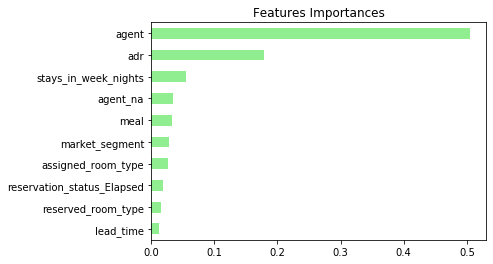

In [212]:
importances = pd.Series(data=m.feature_importances_,index= X_train.columns)
importances_sorted = importances.sort_values().tail(10)
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

In [218]:
def print_score(m,features= list(df.columns)):
    reg_metrics = {
                        "Accuracy Score": [metrics.accuracy_score(y_train, m.predict(X_train[features])), metrics.accuracy_score(y_valid, m.predict(X_valid[features])),metrics.accuracy_score(y_test, m.predict(X_test[features]))],
                        "F1 Score": [metrics.f1_score(y_train, m.predict(X_train[features])), metrics.f1_score(y_valid, m.predict(X_valid[features])), metrics.f1_score(y_test, m.predict(X_test[features]))],
                        "Roc Auc Score": [metrics.roc_auc_score(y_train, m.predict(X_train[features])), metrics.roc_auc_score(y_valid, m.predict(X_valid[features])), metrics.roc_auc_score(y_test, m.predict(X_test[features]))]
                        
                  }
    
    df_reg_metrics = pd.DataFrame.from_dict(reg_metrics, orient='index', columns=["Train", "Validation", "Test"])
    if hasattr(m, "oob_score_"):
        print(f"OOB score: {m.oob_score_}")
    return df_reg_metrics

In [220]:
m = RandomForestClassifier(n_estimators=60, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
%time m.fit(X_train[['agent']], y_train)
print_score(m,['agent'])

Wall time: 1.69 s
OOB score: 0.9093726442750649


,Train,Validation,Test
Accuracy Score,0.909670,0.907865,0.909683
F1 Score,0.849384,0.847940,0.849477
Roc Auc Score,0.872566,0.871165,0.872592


In [265]:
df3 = pd.read_feather("tmp/hotel_bookings")

In [266]:
df3['hotel_Resort Hotel']

0         1
1         1
2         1
3         1
4         1
         ..
119385    0
119386    0
119387    0
119388    0
119389    0
Name: hotel_Resort Hotel, Length: 119390, dtype: uint8

In [267]:
df3['agent']

0           NaN
1           NaN
2           NaN
3         304.0
4         240.0
          ...  
119385    394.0
119386      9.0
119387      9.0
119388     89.0
119389      9.0
Name: agent, Length: 119390, dtype: float64

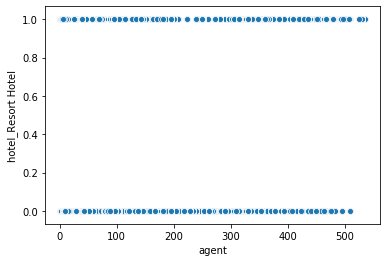

In [233]:
import seaborn as sns 
sns.scatterplot(x = 'agent', y ='hotel_Resort Hotel',data = df3)